# Τεχνολογίες Κινητού Υπολογισμού με Μηχανική Μάθηση
### Ακ. Έτος 2024-2025
## 2η Εργαστηριακή Άσκηση: "Βελτιστοποίηση Νευρωνικών Δικτύων για Ανάπτυξη σε Συσκευές με Περιορισμένους Πόρους"

# Βιβλιοθήκες

Η βιβλιοθήκη `tensorflow_model_optimization` που χρειαζόμαστε για την κβαντοποίηση είναι η μόνη -από αυτές που θα χρειαστούμε- που δεν είναι προεγκατεστημένη στο Kaggle, οπότε την εγκαθιστούμε εμείς.

In [59]:
!pip install tensorflow_model_optimization --quiet

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [60]:
import numpy as np # linear algebra
import pandas as pd # dataset
import tensorflow as tf # neural networks
import tensorflow_model_optimization as tfmot # neural networks optimization (quantization)
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow_model_optimization.python.core.keras.compat import keras
# import tf_keras as keras 
import matplotlib.pyplot as plt # plots

# scikit-learn for data preprocessing, metrics, etc.
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split

# Συναρτήσεις

Παρακάτω σας δίνεται η συνάρτηση `plot_history(history)`. Δέχεται ως είσοδο το αντικείμενο History που επιστρέφει η μέθοδος `model.fit(...)` και δημιουργεί ένα διάγραμμα με τις καμπύλες εκπαίδευσης του μοντέλου.

In [61]:
def plot_history(history):

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    
    num_epochs = len(history.epoch)
    epochs = [x+1 for x in history.epoch]
    
    ax1.plot(epochs, history.history["loss"], marker='.', label="train_loss")
    ax1.plot(epochs, history.history["val_loss"], marker='.', label="val_loss")
    ax1.set_ylabel("Loss")
    ax1.set_title("Train and Validation Loss Over Epochs", fontsize=14)
    ax1.set_xticks(epochs[0::int(num_epochs/5)], epochs[0::int(num_epochs/5)])
    ax1.set_xlabel("Epochs")
    ax1.legend()
    ax1.grid()
    
    ax2.plot(epochs, history.history["accuracy"], marker='.', label="train_accuracy")
    ax2.plot(epochs, history.history["val_accuracy"], marker='.', label="val_accuracy")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Train and Validation Accuracy Over Epochs", fontsize=14)
    ax2.set_xticks(epochs[0::int(num_epochs/5)], epochs[0::int(num_epochs/5)])
    ax2.set_xlabel("Epochs")
    ax2.legend()
    ax2.grid()

    ax3.plot(epochs, history.history["f1_score"], marker='.', label="train_f1_score")
    ax3.plot(epochs, history.history["val_f1_score"], marker='.', label="val_f1_score")
    ax3.set_ylabel("F1-Score")
    ax3.set_title("Train and Validation F1-Score Over Epochs", fontsize=14)
    ax3.set_xticks(epochs[0::int(num_epochs/5)], epochs[0::int(num_epochs/5)])
    ax3.set_xlabel("Epochs")
    ax3.legend()
    ax3.grid()
    
    plt.show()
    
    return

# Σύνολο Δεδομένων

Στο πλαίσιο της εργαστηριακής άσκησης θα χρησιμοποιηθεί ένα υποσύνολο του συνόλου δεδομένων **[CICIoT2023](https://www.unb.ca/cic/datasets/iotdataset-2023.html)**, το οποίο περιλαμβάνει 46 χαρακτηριστικά ροών κίνησης πακέτων IP σε ένα δίκτυο IoT με σκοπό την ανίχνευση εισβολών (intrusion detection).

Το αρχικό σύνολο δεδομένων περιέχει πάνω από 45 εκατομμύρια δείγματα σε 34 κλάσεις, με μια κλάση να αντιστοιχεί στην καλοήθη (benign) κίνηση και οι υπόλοιπες 33 να αφορούν διάφορες δικτυακές επιθέσεις. Οι 33 επιθέσεις μπορούν να ομαδοποιηθούν σε 7 κατηγορίες, ώστε τελικά να προκύψει ένα πρόβλημα ταξινόμησης 8 κλάσεων.

Ένα βασικό ζήτημα που αντιμετωπίζουν τα περισσότερα δικτυακά σύνολα δεδομένων είναι η ανισορροπία των κλάσεων (class imbalance), η οποία προκύπτει από την ετερογένεια της δικτυακής κίνησης, καθώς διαφορετικά είδη επιθέσεων παράγουν διαφορετικό όγκο πακέτων και ροών. Το αρχικό σύνολο δεδομένων, χωρισμένο στις 8 κατηγορίες, περιλαμβάνει το πλήθος δειγμάτων ανά κατηγορία που φαίνεται στην 3η στήλη του παρακάτω πίνακα. Το σύνολο δεδομένων που σας δίνεται είναι ένα υποσύνολο του αρχικού, ώστε τα δείγματα κάθε κατηγορίας να μην ξεπερνούν τα 150 χιλιάδες, οδηγώντας σε συνολικά περίπου 940 χιλιάδες δείγματα, γι' αυτό και ονομάζουμε το υποδειγματοληπτημένο σύνολο δεδομένων **CICIoT2023-1M**. Η ανισορροπία δεν είναι τόσο έντονη όσο στο αρχικό, ωστόσο συνεχίζει να υπάρχει σε έναν βαθμό.

|ΑΑ    |Κατηγορία                            |Αρχικό Πλήθος Δειγμάτων| Υποδειγματοληψία | 
|------|-------------------------------------|----------------|---------|
|1     |DDoS (Distributed Denial of Service) |33,984,560      | 150,000 |
|2     |DoS (Denial of Service)              |8,090,738       | 150,000 |
|3     |Mirai                                |2,634,124       | 150,000 |
|4     |Benign                               |1,098,195       | 150,000 |
|5     |Spoofing                             |486,504         | 150,000 |
|6     |Recon (Reconnaissance)               |354,565         | 150,000 |
|7     |Web                                  |24,829          | 24,829  |
|8     |BruteForce                           |13,064          | 13,064  |
|-     |ΣΥΝΟΛΟ                               |46,686,579      | 937,893 |

Κάθε δείγμα (γραμμή) στο σύνολο δεδομένων αφορά μια **ροή (flow)**. Μια ροή αντιπροσωπεύει μια ακολουθία πακέτων IP που μοιράζονται ένα σύνολο κοινών χαρακτηριστικών, που συνήθως ρέουν μεταξύ της ίδιας πηγής και προορισμού μέσα σε ένα συγκεκριμένο χρονικό πλαίσιο. Τυπικά ορίζεται από έναν συνδυασμό πεδίων στις επικεφαλίδες των πακέτων IP, που συχνά αποκαλούνται "5-πλειάδες" (5-tuples) στα δίκτυα IP:
1. Διεύθυνση IP πηγής: Προσδιορίζει τον αποστολέα του πακέτου.
2. Διεύθυνση IP προορισμού: Προσδιορίζει τον παραλήπτη του πακέτου.
3. Θύρα προέλευσης: Προσδιορίζει τον αριθμό θύρας στο μηχάνημα προέλευσης (για πρωτόκολλα όπως το TCP και το UDP).
4. Θύρα προορισμού: Προσδιορίζει τον αριθμό θύρας στο μηχάνημα προορισμού (για πρωτόκολλα όπως το TCP και το UDP).
5. Πρωτόκολλο: Υποδεικνύει το πρωτόκολλο του επιπέδου μεταφοράς (π.χ. TCP, UDP, ICMP).

Μια ροή μπορεί να περιλαμβάνει πρόσθετα πεδία αλλά η 5-πλειάδα είναι συνήθως επαρκής για τον μοναδικό προσδιορισμό μιας ροής.

## Σύνολο Δεδομένων Εκπαίδευσης

Το σύνολο που σας δίνεται για εκπαίδευση (train.csv) περιέχει το 90% των δειγμάτων, δηλαδή 844103 δείγματα. Οι 46 πρώτες στήλες του dataframe περιέχουν τα χαρακτηριστικά και η τελευταία περιέχει τις ετικέτες.

In [62]:
file = "/kaggle/input/mcml-24-25-lab-2-intrusion-detection-in-iot/train.csv"
df_train = pd.read_csv(file)

In [63]:
df_train.shape

(844103, 47)

In [64]:
df_train.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,3.206987,6801.30,7.00,64.40,272642.985162,272642.985162,0.0,0.0,0.0,0.0,...,115.385548,187.60,1.665194e+08,13.5,17.320894,163.550795,1.362632e+04,1.00,244.60,Benign
1,1.544619,3416618.90,6.00,185.80,927.412753,927.412753,0.0,0.0,0.0,0.0,...,1250.704543,2811.50,2.255917e-04,5.5,48.108444,1768.763327,2.268369e+06,0.90,38.50,Spoofing
2,131.762750,15188.25,7.56,67.70,203.062327,203.062327,0.0,0.0,0.0,0.0,...,75.119099,127.91,8.324383e+07,9.5,15.285089,106.358994,8.583812e+03,0.93,141.55,Recon
3,0.167141,30439.08,16.34,74.32,3528.975541,3528.975541,0.0,0.0,0.0,0.0,...,22.269627,92.00,8.301651e+07,9.5,10.497624,31.699151,1.228085e+04,0.06,141.55,DoS
4,0.000000,52.92,5.88,62.72,575.139958,575.139958,0.0,0.0,0.0,0.0,...,0.189317,54.12,8.294674e+07,9.5,10.397101,0.268643,2.796946e-01,0.13,141.55,DoS


In [65]:
df_train['label'].value_counts()

label
Mirai         135212
Benign        135087
Spoofing      135007
Recon         134920
DoS           134888
DDoS          134815
Web            22426
BruteForce     11748
Name: count, dtype: int64

## Σύνολο Δεδομένων Ελέγχου

Το σύνολο που σας δίνεται για έλεγχο (test.csv) περιέχει το υπόλοιπο 10% των δειγμάτων, δηλαδή 93790 δείγματα. Η πρώτη στήλη του dataframe περιέχει έναν ακέραιο αριθμό, που αποτελεί το αναγνωριστικό κάθε δείγματος και οι υπόλοιπες 46 περιέχουν τα χαρακτηριστικά. **Οι ετικέτες για το σύνολο ελέγχου δεν είναι διαθέσιμες.**

In [66]:
file = "/kaggle/input/mcml-24-25-lab-2-intrusion-detection-in-iot/test.csv"
X_test = pd.read_csv(file)

In [67]:
# remove id column
X_test.shape

(93790, 47)

In [68]:
X_test.head()

,id,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,771638,0.018130,71.8,6.0,153.3,31.720781,31.720781,0,0,0,...,56.953016,1.141231,55.6,3.076506e-03,5.5,10.672303,1.613945,2.182454,0.6,38.50
1,528847,0.513357,753493.8,6.0,123.0,976.700469,976.700469,0,0,0,...,66.000000,0.000000,66.0,2.233980e-04,5.5,11.489125,0.000000,0.000000,0.0,38.50
2,342335,0.119345,227223.1,17.0,64.0,3435.607239,3435.607239,0,0,0,...,554.000000,0.000000,554.0,8.378493e+07,9.5,33.286634,0.000000,0.000000,0.0,141.55
3,372124,0.000000,0.0,47.0,64.0,20.053136,20.053136,0,0,0,...,592.000000,0.000000,592.0,8.368115e+07,9.5,34.409301,0.000000,0.000000,0.0,141.55
4,328160,0.000000,0.0,47.0,64.0,72.516256,72.516256,0,0,0,...,592.000000,0.000000,592.0,8.367705e+07,9.5,34.409301,0.000000,0.000000,0.0,141.55


# Προεπεξεργασία Δεδομένων

Τα 46 χαρακτηριστικά του συνόλου δεδομένων φαίνονται παρακάτω. Για μια πιο λεπτομερή περιγραφή ρίξτε μια ματιά στο άρθρο:

Neto, Euclides Carlos Pinto, et al. "CICIoT2023: A real-time dataset and benchmark for large-scale attacks in IoT environment." *Sensors* 23.13 (2023): 5941.

[https://www.mdpi.com/1424-8220/23/13/5941](https://www.mdpi.com/1424-8220/23/13/5941)

In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844103 entries, 0 to 844102
Data columns (total 47 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    844103 non-null  float64
 1   Header_Length    844103 non-null  float64
 2   Protocol Type    844103 non-null  float64
 3   Duration         844103 non-null  float64
 4   Rate             844103 non-null  float64
 5   Srate            844103 non-null  float64
 6   Drate            844103 non-null  float64
 7   fin_flag_number  844103 non-null  float64
 8   syn_flag_number  844103 non-null  float64
 9   rst_flag_number  844103 non-null  float64
 10  psh_flag_number  844103 non-null  float64
 11  ack_flag_number  844103 non-null  float64
 12  ece_flag_number  844103 non-null  float64
 13  cwr_flag_number  844103 non-null  float64
 14  ack_count        844103 non-null  float64
 15  syn_count        844103 non-null  float64
 16  fin_count        844103 non-null  floa

Πρώτα απ' όλα, διαχωρίζουμε το σύνολο εκπαίδευσης σε χαρακτηριστικά και ετικέτες (στήλη label), και διακριτοποιούμε τις ετικέτες.

In [70]:
x_train = df_train.drop(columns=['label'])
y_train = df_train['label']

category_order = ['Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web']
encoder = OneHotEncoder(categories=[category_order], sparse_output=False)
y_train = encoder.fit_transform(y_train.to_numpy().reshape(-1, 1))

### TODO: Προεπεξεργασία Δεδομένων

Όλα τα χαρακτηριστικά του συνόλου δεδομένων είναι αριθμητικά (τύπος float64), επομένως δεν χρειάζεται η διακριτοποίηση κάποιου κατηγορικού χαρακτηριστικού. Επίσης, δεν υπάρχουν ελλείπουσες τιμές.

Τα **απαραίτητα** βήματα προεπεξεργασίας που πρέπει να εφαρμοστούν είναι:
* Διαχωρισμός του συνόλου εκπαίδευσης στα υποσύνολα εκπαίδευσης (train) και επικύρωσης (val). Μπορείτε να δοκιμάσετε διάφορα ποσοστά διαχωρισμού.
* Κανονικοποίηση (normalization). Αν η μέθοδος κανονικοποίησης που θα εφαρμόσετε απαιτεί προσαρμογή στα δεδομένα, τότε αυτή η προσαρμογή πρέπει να γίνει ***μόνο** στο σύνολο εκπαίδευσης (μετά και τον διαχωρισμό του συνόλου επικύρωσης)*. Παράδειγμα αποτελεί η κανονικοποίηση z-score, όπου απαιτείται η εκμάθηση της μέσης τιμής και της τυπικής απόκλισης κάθε χαρακτηριστικού στο σύνολο εκπαίδευσης, προτού μετασχηματίσει τα δεδομένα. Δείτε [εδώ](https://scikit-learn.org/1.5/modules/preprocessing.html#).

Τα **προαιρετικά** βήματα προεπεξεργασίας που μπορούν να εφαρμοστούν είναι:
* Επαύξηση του συνόλου εκπαίδευσης για την αντιμετώπιση της ανισορροπίας των κλάσεων. Μπορείτε να χρησιμοποιήσετε τις βιβλιοθήκες [imblearn](https://imbalanced-learn.org/stable/user_guide.html) και [ctgan](https://github.com/sdv-dev/CTGAN).
* Μηχανική χαρακτηριστικών. Χρησιμοποιήστε αλγορίθμους όπως οι PCA, LDA, t-SNE για εξαγωγή χαρακτηριστικών και το module [sklearn.feature_selection](https://scikit-learn.org/1.5/modules/feature_selection.html) για επιλογή χαρακτηριστικών.

Θέλουμε να χωρίσουμε το σύνολο δεδομένων σε train, val, test σε ποσοστό 80/10/10. Έχουμε ήδη χωρίσει σε train/test με ποσοστό 90/10, άρα αυτό που πρέπει να γίνει είναι να χωριστεί το train σύνολο στα υποσύνολα train/val με ποσοστό επί του αρχικού train $ \frac{8}{9}/\frac{1}{9} $.

In [71]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/9, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (750313, 46)
Validation set size: (93790, 46)
Test set size: (93790, 47)


In [72]:
qt = QuantileTransformer(output_distribution='normal')
X_train = qt.fit_transform(X_train)
X_val = qt.transform(X_val)

# TODO: Κατασκευή Μοντέλου

Σχετικά με το μοντέλο που θα κατασκευάσετε για την επίλυση του προβλήματος της ανίχνευσης εισβολών, υπάρχουν οι εξής περιορισμοί:
* Τα επίπεδα του μοντέλου θα πρέπει να επεξεργάζονται την είσοδο σειριακά (sequentially). Επομένως, δεν μπορούν να υπάρχουν παράλληλοι κλάδοι (branches) μέσα στο δίκτυο.
* Δεν μπορούν να χρησιμοποιηθούν όλα τα επίπεδα που είναι διαθέσιμα στο module [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) λόγω των περιορισμών της κβαντοποίησης. Φροντίστε ότι παρακάτω θα μπορεί να εφαρμοστεί στο μοντέλο επίγνωση κβαντοποίησης.

Επιπλέον, δεν υπάρχει περιορισμός ως προς τις τιμές των υπερπαραμέτρων εκπαίδευσης. Μπορείτε να δοκιμάσετε διάφορα μεγέθη δέσμης, διάφορους βελτιστοποιητές, καθώς και διάφορες τιμές για τις υπερπαραμέτρους αυτών (π.χ. ρυθμός μάθησης).

Κατασκευάστε το μοντέλο σας και εκπαιδεύστε το.

In [73]:
model = keras.Sequential([
    # input layer
    keras.Input(shape=(46,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    # output layer
    keras.layers.Dense(8, activation='softmax')
])

Με τη μέθοδο ``summary`` μπορούμε να δούμε την αρχιτεκτονική του μοντέλου, δηλαδή τα επίπεδά του, το σχήμα εξόδου και το πλήθος των παραμέτρων τους. Η πρώτη διάσταση των εξόδων αντιστοιχεί στο batch size (μέγεθος δέσμης) και η τιμή None υποδηλώνει ότι το μοντέλο μπορεί να δεχτεί μεταβλητό batch size, δηλαδή οποιοδήποτε πλήθος εικόνων εισόδου ταυτόχρονα.

Με βάση την εκφώνηση, ο συνολικός αριθμός των παραμέτρων του μοντέλου (Total params) δεν θα πρέπει να ξεπερνά τις 10.000.

In [74]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                1504      
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
Total params: 4280 (16.72 KB)
Trainable params: 4280 (16.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Για να εκπαιδεύσουμε ένα μοντέλο πρέπει να ορίσουμε τον βελτιστοποιητή (δηλαδή τον αλγόριθμο καθόδου κλίσης), τη συνάρτηση απώλειας και τη μετρική (ή τις μετρικές) αξιολόγησης, τα οποία ορίζονται με τη μέθοδο `compile`.

In [75]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', keras.metrics.F1Score(average='macro')]
)

Για να αποφύγουμε την υπερπροσαρμογή (overfitting) αλλά και για να γνωρίζουμε πότε πρέπει να σταματήσει η εκπαίδευση, εφαρμόζουμε την τεχνική του πρόορου τερματισμού (early stopping). Με αυτό τον τρόπο, παρακολουθούμε (``monitor``) το σφάλμα επικύρωσης (val_loss) σε κάθε εποχή κι αν αυτό δεν μειωθεί περαιτέρω για έναν αριθμό από εποχές (``patience``), τότε η εκπαίδευση σταματά (καθώς αυτό αποτελεί σημάδι υπερπροσαρμογής). Όταν ο πρόορος τερματισμός ενεργοποιηθεί, η εκπαίδευση θα σταματήσει και στο μοντέλο θα φορτωθούν τα βάρη της καλύτερης εποχής, δηλαδή της εποχής με το χαμηλότερο σφάλμα επικύρωσης (``restore_best_weights=True``).

In [76]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

Η εκπαίδευση ξεκινά με τη μέθοδο ``fit``, στην οποία δίνουμε τα training και validation sets, ορίζουμε το μέγεθος δέσμης και μια σχετικά μεγάλη τιμή για τον μέγιστο αριθμό εποχών (π.χ. 200), καθώς θέλουμε η εκπαίδευση να σταματήσει λόγω του early stopping. Κατά τη διάρκεια της εκπαίδευσης μπορούμε να δούμε στο τέλος κάθε εποχής την απώλεια του μοντέλου και τις μετρικές αξιολόγησης για κάθε υποσύνολο.

In [77]:
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    validation_data=(X_val, y_val),
    batch_size=256,
    callbacks = None,
    # callbacks=[early_stopping]
)

Epoch 1/200
2931/2931 [==============================] - 11s 3ms/step - loss: 0.5877 - accuracy: 0.7821 - f1_score: 0.6327 - val_loss: 0.3617 - val_accuracy: 0.8689 - val_f1_score: 0.7483
Epoch 2/200
2931/2931 [==============================] - 10s 3ms/step - loss: 0.3147 - accuracy: 0.8860 - f1_score: 0.7780 - val_loss: 0.2809 - val_accuracy: 0.8993 - val_f1_score: 0.8049
Epoch 3/200
2931/2931 [==============================] - 10s 3ms/step - loss: 0.2667 - accuracy: 0.9030 - f1_score: 0.8124 - val_loss: 0.2519 - val_accuracy: 0.9071 - val_f1_score: 0.8223
Epoch 4/200
2931/2931 [==============================] - 10s 3ms/step - loss: 0.2476 - accuracy: 0.9073 - f1_score: 0.8224 - val_loss: 0.2447 - val_accuracy: 0.9061 - val_f1_score: 0.8238
Epoch 5/200
2931/2931 [==============================] - 10s 3ms/step - loss: 0.2360 - accuracy: 0.9105 - f1_score: 0.8308 - val_loss: 0.2290 - val_accuracy: 0.9134 - val_f1_score: 0.8389
Epoch 6/200
2931/2931 [==============================] - 10s

Αφού τελειώσει η εκπαίδευση, από το history του μοντέλου μπορούν να σχεδιαστούν οι καμπύλες εκπαίδευσης χρησιμοποιώντας τη συνάρτηση `plot_history` που σας έχει δοθεί.

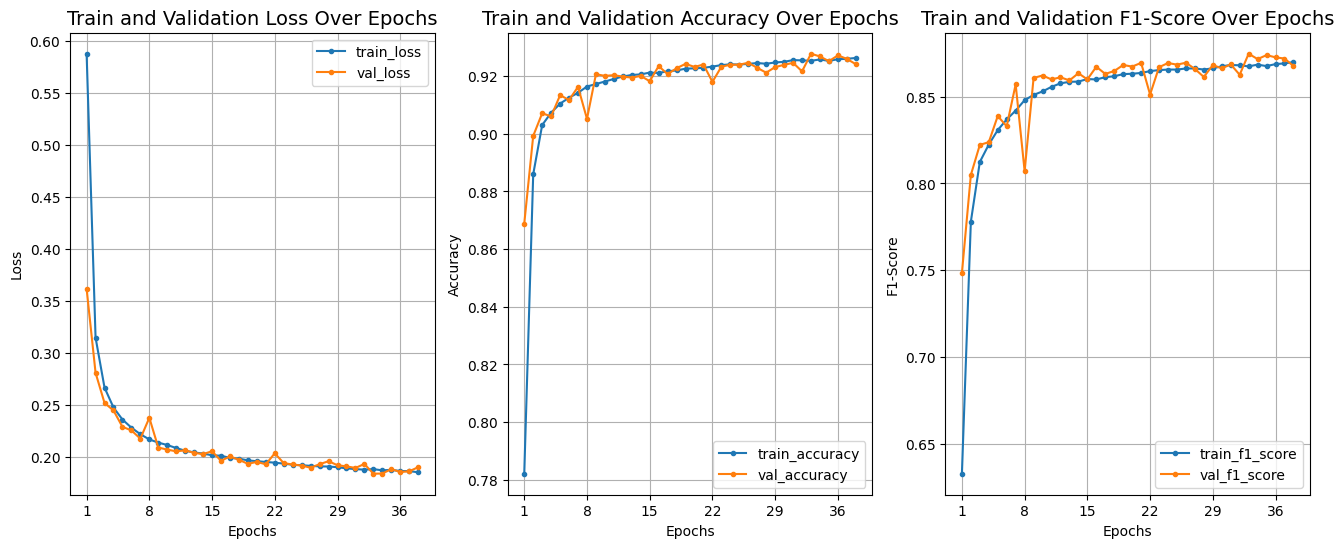

In [78]:
plot_history(history)

In [79]:
loss, accuracy, f1_score = model.evaluate(X_val, y_val)
print("Test loss: {}".format(round(loss, 4)))
print("Test accuracy: {}%".format(round(accuracy*100, 2)))
print("Test f1-score: {}%".format(round(tf.reduce_mean(f1_score).numpy()*100, 2)))

2931/2931 [==============================] - 6s 2ms/step - loss: 0.1839 - accuracy: 0.9278 - f1_score: 0.8748
Test loss: 0.1839
Test accuracy: 92.78%
Test f1-score: 87.48%


# Μοντέλο με Επίγνωση Κβαντοποίησης

Το επόμενο βήμα είναι να εφαρμόσουμε κβαντοποίηση στο εκπαιδευμένο μοντέλο. Με την επίγνωση κβαντοποίησης, το μοντέλο δεν κβαντοποιείται στην πραγματικότητα (οι παράμετροι του παραμένουν στη μορφή float32), αλλά του δίνεται η δυνατότητα να **μιμείται** την κβαντοποίηση κατά τη διάρκεια της εκπαίδευσης, ώστε οι παράμετροι του να βελτιστοποιηθούν με βάση το σφάλμα που προκύπτει από την κβαντισμένη εμπρόσθια διάδοση (και όχι την εμπρόσθια διάδοση με float32 αριθμούς).

Για την εφαρμογή επίγνωσης κβαντοποίησης στο μοντέλο μας χρησιμοποιούμε τη συνάρτηση `quantize_model(model)`, με την οποία εφαρμόζουμε την προκαθορισμένη μέθοδο κβαντοποίησης, την int8. Όπως αναφέρθηκε και παραπάνω, θα πρέπει στα επίπεδα του μοντέλου σας να μπορεί να εφαρμοστεί επίγνωση κβαντοποίησης, οπότε φροντίστε το παρακάτω κελί να εκτελεστεί χωρίς σφάλματα.

In [81]:
quant_aware_model = tfmot.quantization.keras.quantize_model(model)
quant_aware_model.summary(line_length=120)

Model: "sequential_2"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 quantize_layer_2 (QuantizeLayer)                     (None, 46)                                      3                 
                                                                                                                        
 quant_dense_10 (QuantizeWrapperV2)                   (None, 32)                                      1509              
                                                                                                                        
 quant_dense_11 (QuantizeWrapperV2)                   (None, 32)                                      1061              
                                                                                                                        
 quant_den

Στο μοντέλο με επίγνωση κβαντοποίησης έχουν προστεθεί κάποιες non-trainable παράμετροι. Εν γένει, οι non-trainable παράμετροι μπορεί να είναι δύο ειδών:
1. Παράμετροι οι οποίες δεν μεταβάλλονται καθόλου κατά την εκπαίδευση.
2. Παράμετροι οι οποίες μεταβάλλονται αλλά λειτουργούν σαν στατιστικές τιμές και δεν "μαθαίνονται" κατά την εκπαίδευση, αλλά ανανεώνονται με ελάχιστες, μέγιστες, μέσες τιμές, διακυμάνσεις, κ.α.

### TODO: Επεξήγηση Μη Εκπαιδεύσιμων Παραμέτρων

Βρείτε και εξηγήστε ποιος είναι ο λόγος ύπαρξης των μη εκπαιδεύσιμων παραμέτρων κατά την εφαρμογή της επίγνωσης κβαντοποίησης. Αναλύστε το πλήθος και τη λειτουργία τους.

### TODO: Εκπαίδευση Μοντέλου με Επίγνωση Κβαντοποίησης

Εκτελέστε έναν ακόμη γύρο εκπαίδευσης για το εκπαιδευμένο μοντέλο με επίγνωση κβαντοποίησης και σχεδιάστε τις καμπύλες εκπαίδευσης.

Epoch 1/100
2931/2931 [==============================] - 17s 5ms/step - loss: 0.2382 - accuracy: 0.9093 - f1_score: 0.8315 - val_loss: 0.2202 - val_accuracy: 0.9141 - val_f1_score: 0.8436
Epoch 2/100
2931/2931 [==============================] - 15s 5ms/step - loss: 0.2122 - accuracy: 0.9160 - f1_score: 0.8449 - val_loss: 0.2044 - val_accuracy: 0.9180 - val_f1_score: 0.8527
Epoch 3/100
2931/2931 [==============================] - 15s 5ms/step - loss: 0.2115 - accuracy: 0.9160 - f1_score: 0.8441 - val_loss: 0.2034 - val_accuracy: 0.9181 - val_f1_score: 0.8541
Epoch 4/100
2931/2931 [==============================] - 16s 5ms/step - loss: 0.2099 - accuracy: 0.9166 - f1_score: 0.8456 - val_loss: 0.2165 - val_accuracy: 0.9148 - val_f1_score: 0.8392
Epoch 5/100
2931/2931 [==============================] - 16s 5ms/step - loss: 0.2083 - accuracy: 0.9172 - f1_score: 0.8480 - val_loss: 0.2121 - val_accuracy: 0.9156 - val_f1_score: 0.8510
Epoch 6/100
2931/2931 [==============================] - 15s

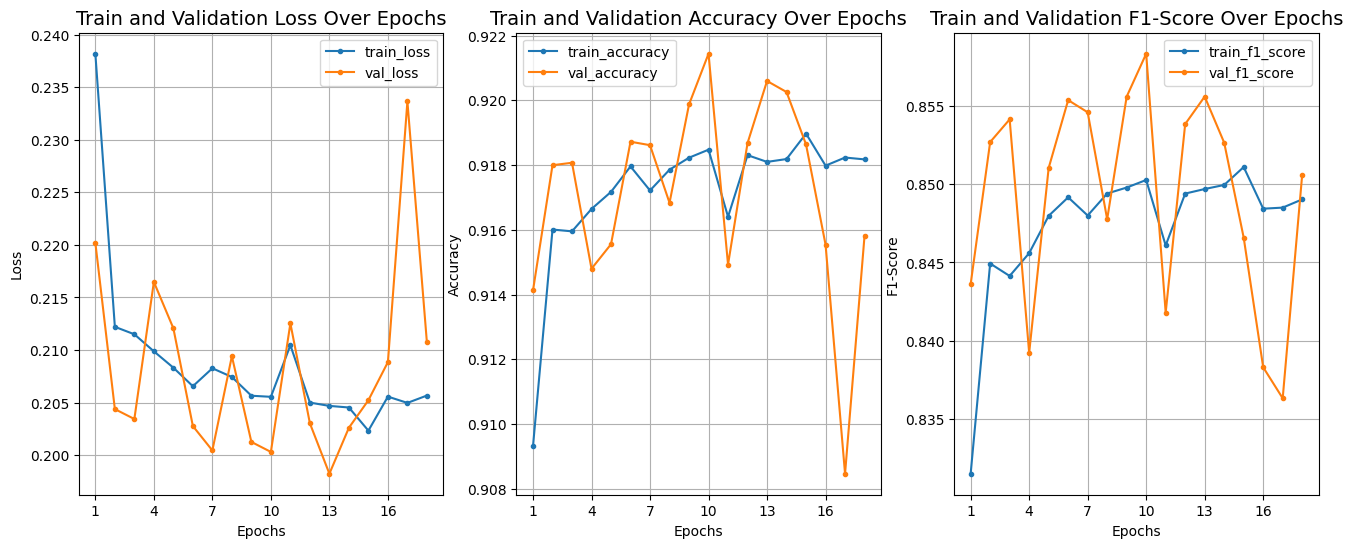

In [82]:
quant_aware_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', keras.metrics.F1Score(average='macro')]
)

history = quant_aware_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    batch_size=256,
    # callbacks=[early_stopping],
    callbacks=None
)

plot_history(history)

Με βάση την εκφώνηση, η ελάχιστη ανεκτή ακρίβεια (top-1 accuracy) για το κβαντισμένο μοντέλο είναι 90%. Εφόσον δεν υπάρχει η δυνατότητα ελέγχου της ακρίβειας στο σύνολο ελέγχου, μπορείτε να βασιστείτε στο σύνολο επικύρωσης.

In [83]:
loss, accuracy, f1_score = quant_aware_model.evaluate(X_val, y_val)
print("Test loss: {}".format(round(loss, 4)))
print("Test accuracy: {}%".format(round(accuracy*100, 2)))
print("Test f1-score: {}%".format(round(tf.reduce_mean(f1_score).numpy()*100, 2)))

2931/2931 [==============================] - 8s 3ms/step - loss: 0.1982 - accuracy: 0.9206 - f1_score: 0.8556
Test loss: 0.1982
Test accuracy: 92.06%
Test f1-score: 85.56%


# Προβλέψεις στο Σύνολο Ελέγχου - Kaggle Competition

Με τον παρακάτω κώδικα παράγονται οι προβλέψεις του κβαντισμένου μοντέλου για το σύνολο ελέγχου και κατασκευάζεται το csv αρχείο προς υποβολή στο kaggle.

Η πρώτη στήλη του αρχείου προς υποβολή περιέχει το ID του δείγματος, η δεύτερη το πλήθος των παραμέτρων του μοντέλου και οι υπόλοιπες 8 τις πεποιθήσεις του μοντέλου για κάθε κλάση.

In [84]:
model_params = model.count_params()

X_test_ = X_test.drop(columns=['id'])
X_test_ = qt.transform(X_test_)
pred = quant_aware_model.predict(X_test_, verbose=0)

In [85]:
df_pred = pd.DataFrame(columns=['id', 'params', 'Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web'])

for id, prediction in zip(X_test['id'], pred):
    new_row = [id] + [model_params] + prediction.tolist()
    df_pred.loc[len(df_pred)] = new_row
    print(f"{len(df_pred)}/{len(X_test)}", end='\r')

df_pred['id'] = df_pred['id'].astype(int)
df_pred['params'] = df_pred['params'].astype(int)

In [86]:
df_pred.to_csv("predictions.csv", index=False)

# Αποθήκευση Μοντέλου

Το κβαντισμένο μοντέλο μπορεί να αποθηκευτεί στη μορφή TFLite, μια ελαφριά έκδοση του TensorFlow που έχει σχεδιαστεί για την ανάπτυξη μοντέλων σε κινητές συσκευές, ενσωματωμένα συστήματα και άλλα περιβάλλοντα με περιορισμούς πόρων. Μπορείτε να ανεβάσετε το αρχείο tflite στο [Netron](https://netron.app/) για μια οπτική αναπαράσταση της αρχιτεκτονικής του δικτύου.

In [87]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open('model_int.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


# TODO: Τελικά Αποτελέσματα και Συμπεράσματα

Εξηγήστε τη διαδικασία που ακολουθήσατε για να φτάσετε στο βέλτιστο μοντέλο.

Αναλύστε ποιες μεθόδους προεπεξεργασίας, ποια ποσοστά διαχωρισμού, ποιες τεχνικές επαύξησης δεδομένων, ποιους αλγορίθμους επιλογής/εξαγωγής χαρακτηριστικών δοκιμάσατε και τι επίδραση είχαν στην απόδοση του μοντέλου.

Αναφέρετε ό,τι άλλο θεωρείτε άξιο αναφοράς.

Τι σκορ δίνει το Kaggle για το τελικό σας μοντέλο;